In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import gc
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# load the dataset
from tensorflow.keras.preprocessing.image import img_to_array, load_img


directory = '../input/brain-tumor-classification-mri'
train_dir = os.path.join(directory, 'Training')
test_dir = os.path.join(directory, 'Testing')

categories = [] # the names of the different types of brain tumors will be saved here
train_labels = [] # the types of tumors will be coded 0 - 3
train_images = []
images_path = []


# some image properties
img_height = 128
img_width = 128


for index, category in enumerate(sorted(os.listdir(train_dir))):
    categories.append(category)
    category_loc = os.path.join(train_dir, category)
    
    for i, file_name in enumerate(sorted(os.listdir(category_loc))):
        file_path = os.path.join(category_loc, file_name)
        images_path.append(file_path)
        image = load_img(file_path, color_mode='rgb', target_size=(img_height, img_width)) # load the image
        image = img_to_array(image) # convert each image to an array
        train_images.append(image) # append each array to the train images list we earlier created
        train_labels.append(index)

In [3]:
len(train_images), len(train_labels)

(2870, 2870)

In [4]:
train_labels[:5]

[0, 0, 0, 0, 0]

In [5]:
train_labels[-1]

3

In [6]:
categories

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [7]:
train_images[4].shape

(128, 128, 3)

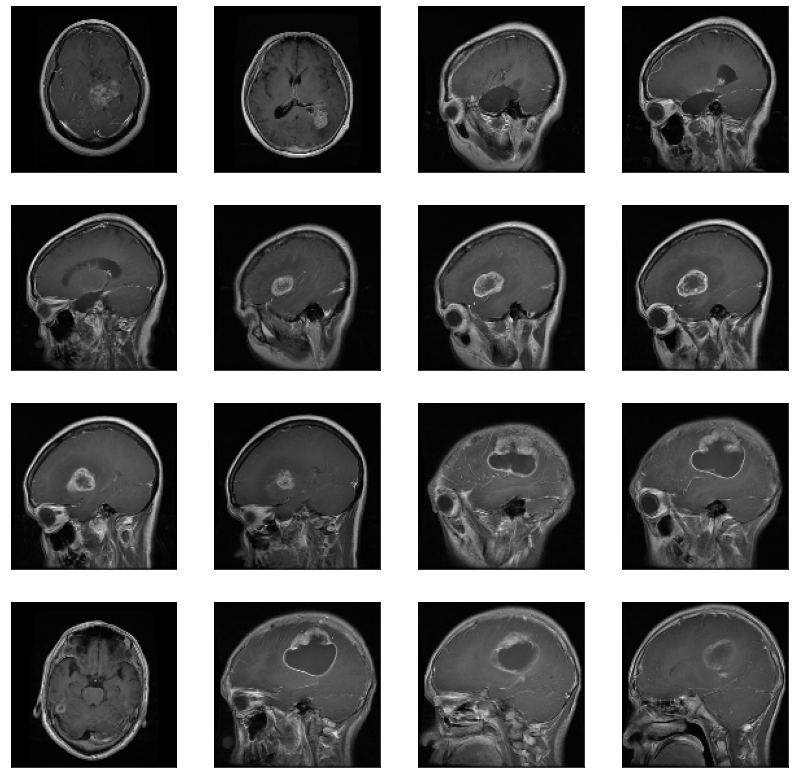

In [8]:
# let's visualize some of the images

images_path = images_path[:16]# visualize for first 16 images in the dataset
plt.figure(figsize=(14, 14)) # create a new figure plot
index = 0

for i in range(len(images_path)):
    plt.subplot(4, 4, i+ 1) # start plotting each image from the first
    plt.xticks([])
    plt.yticks([])
    
    sign = images_path[i]
    img = load_img(sign, target_size=(img_height, img_width))
    plt.imshow(img)
    
plt.show()

In [9]:
# alright, let's convert the images into arrays

train_labels = np.array(train_labels)
train_images = np.array(train_images)

In [10]:
train_images.shape

(2870, 128, 128, 3)

In [11]:
# clip the pixel values in the train images array to range 0 -1
train_images = train_images[:]/255

In [12]:
# now, let's split into train & validation sets

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, random_state=42, shuffle=True, test_size=0.1)

In [13]:
len(X_train), len(X_val)

(2583, 287)

In [14]:
y_train[0]

1

## ML Models

### Baseline model

In [15]:
model = models.Sequential(name='baseline_model')
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

2022-07-29 19:38:05.399875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 19:38:05.511245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 19:38:05.512044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 19:38:05.513605: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
model.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)          

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [18]:
#early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("brain_tumor_baseline.h5", save_best_only=True)

In [19]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), 
                    callbacks=[checkpoint_cb])

2022-07-29 19:38:08.923194: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-07-29 19:38:10.306527: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


81/81 [==============================] - 9s 20ms/step - loss: 0.9185 - acc: 0.6121 - val_loss: 0.7438 - val_acc: 0.7352
Epoch 2/20
81/81 [==============================] - 1s 12ms/step - loss: 0.5231 - acc: 0.7944 - val_loss: 0.6063 - val_acc: 0.7596
Epoch 3/20
81/81 [==============================] - 1s 12ms/step - loss: 0.3455 - acc: 0.8664 - val_loss: 0.4763 - val_acc: 0.8397
Epoch 4/20
81/81 [==============================] - 1s 12ms/step - loss: 0.2330 - acc: 0.9164 - val_loss: 0.5035 - val_acc: 0.8014
Epoch 5/20
81/81 [==============================] - 1s 12ms/step - loss: 0.1423 - acc: 0.9470 - val_loss: 0.4199 - val_acc: 0.8502
Epoch 6/20
81/81 [==============================] - 1s 12ms/step - loss: 0.0660 - acc: 0.9791 - val_loss: 0.6140 - val_acc: 0.8014
Epoch 7/20
81/81 [==============================] - 1s 14ms/step - loss: 0.0507 - acc: 0.9826 - val_loss: 0.4241 - val_acc: 0.8885
Epoch 8/20
81/81 [==============================] - 1s 12ms/step - loss: 0.0570 - acc: 0.9806 

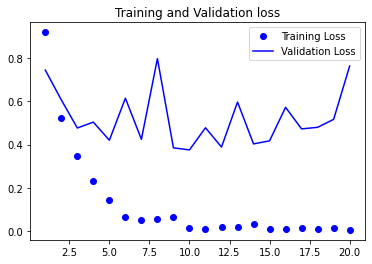

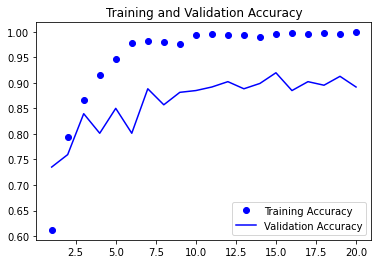

In [20]:
loss = history.history['loss']
acc = history.history['acc']

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

epochs = range(1, len(loss)+ 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation loss')
plt.legend()


plt.figure()
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

## The Test set

In [21]:
# load the images
test_labels = [] 
test_images = []

for index, category in enumerate(sorted(os.listdir(test_dir))):
    category_loc = os.path.join(train_dir, category)
    
    for i, file_name in enumerate(sorted(os.listdir(category_loc))):
        file_path = os.path.join(category_loc, file_name)
        image = load_img(file_path, color_mode='rgb', target_size=(img_height, img_width)) # load the image
        image = img_to_array(image) # convert each image to an array
        test_images.append(image) # append each array to the train images list we earlier created
        test_labels.append(index)
        
# convert the images & labels to numpy arrays
test_labels = np.array(test_labels)
test_images = np.array(test_images)

# clip the image to the range 0-1 pixels
test_images = test_images[:]/255

### Evaluating the performance on the test set

In [22]:
model.evaluate(test_images, test_labels)

90/90 [==============================] - 1s 6ms/step - loss: 0.1191 - acc: 0.9739


[0.11912976950407028, 0.9738675951957703]

The Baseline model seemed to perform very well on the dataset. Let's visualize how this works

In [23]:
categories

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [24]:
tumor_dict = dict(enumerate(categories))
tumor_dict

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

In [25]:
# let's shuffle the test dataset

indices = np.arange(test_images.shape[0])
np.random.shuffle(indices)
test_images = test_images[indices]
test_labels = test_labels[indices]

In [26]:
# let's visualize some predictions

test_images = test_images[:30]
test_labels = test_labels[:30]
predict_proba = model.predict(test_images)
prediction = np.argmax(predict_proba, axis=1)

In [27]:
prediction

array([0, 1, 1, 1, 1, 3, 3, 3, 0, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 2, 1,
       2, 2, 0, 1, 0, 1, 3, 1])

In [28]:
# for the predicted cancer class

predicted_tumor = []

for val in prediction:
    for key, value in tumor_dict.items():
        if val == key:
            predicted_tumor.append(value)

In [29]:
predicted_tumor[:5]

['glioma_tumor',
 'meningioma_tumor',
 'meningioma_tumor',
 'meningioma_tumor',
 'meningioma_tumor']

In [30]:
# for the labeled tumor type

actual_tumor_type = test_labels
actual_tumor_type = list(actual_tumor_type)

actual_tumor = []

for val in actual_tumor_type:
    for key, value in tumor_dict.items():
        if val == key:
            actual_tumor.append(value)
actual_tumor[:5]

['glioma_tumor',
 'meningioma_tumor',
 'meningioma_tumor',
 'meningioma_tumor',
 'meningioma_tumor']

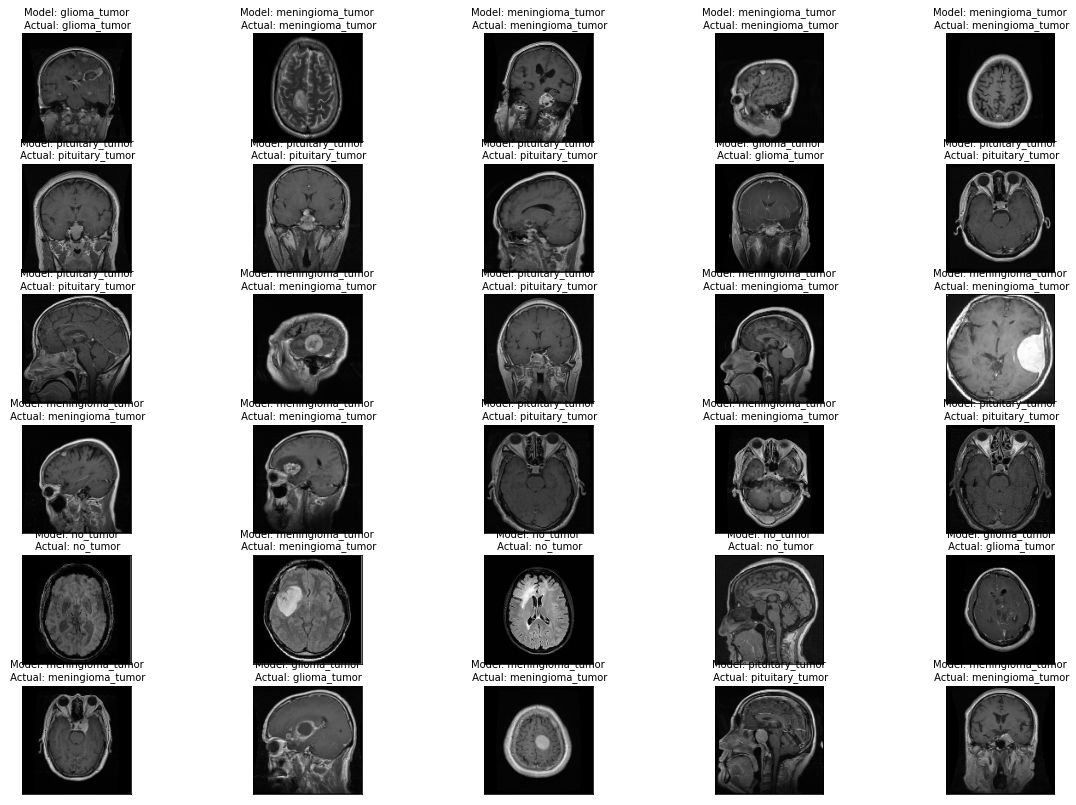

In [31]:
# now to visualize this information

plt.figure(figsize=(20, 14))

for i in range(len(prediction)): # for 30 images
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    
    # add each image to subplot and plot it
    image = test_images[i]
    plt.imshow(image)
    
    # add the predicted and actual labeled tumor type
    
    plt.title(f'Model: {predicted_tumor[i]}\n Actual: {actual_tumor[i]}', fontsize=10)
    
plt.show()

### Evaluating a single image

In [32]:
import pickle

with open('tumors_dict.pickle', 'wb') as handle:
    pickle.dump(tumor_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
def evaluate(image_path, model_path, dict_path, image_height=128, image_width=128, n_channels=3):
    """Function for a python script to determine the category of the input
    Imports the necessary dependencies for the function to work anywhere.
    Args:
        image_path - path to the jpg file input.
        model_path - path to the h5 model file.
        dict_path - path to the pickle dictionary for classes
        image_height/width - required shape for image. defaults to 128
        n_channels - 3 for rgb. 1 for black & white
    """
    # import dependencies
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # suppress tensorflow warnings
    import numpy as np
    import tensorflow as tf
    import matplotlib.pyplot as plt
    from tensorflow import keras
    from keras import models
    import pickle
    from tensorflow.keras.preprocessing.image import load_img, img_to_array

    # load the model
    model = models.load_model(model_path)
    
    # load the dict
    with open(dict_path, 'rb') as handle:
        class_dict = pickle.load(handle)
    
    # preprocess the image
    image = load_img(image_path, target_size=(image_height, image_width))

    # plot the image
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # convert image to array & clip to 0-1 range
    image = img_to_array(image)
    image = np.array(image)
    image = image[:]/255
    image = np.expand_dims(image, axis=0)

    # feed image to model & predict
    pred = model.predict(image)
    pred = np.argmax(pred, axis=1)
    
    for key, value in class_dict.items():
        if pred == key:
            predicted_tumor = class_dict[key]
            print(f"Model Predicted: {predicted_tumor}")
    plt.title(predicted_tumor)
    plt.show()

In [34]:
dict_path = './tumors_dict.pickle'
model_path = './brain_tumor_baseline.h5'

Model Predicted: no_tumor


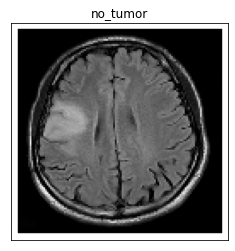

In [35]:
image_path = '../input/glioma/970586.fig.008a.jpg'
evaluate(image_path, model_path, dict_path)

Model Predicted: no_tumor


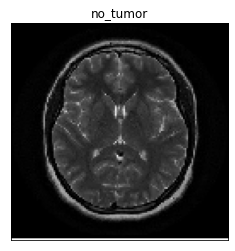

In [36]:
image_path = '../input/glioma/1_BGxLxoHd8MG9m8gesYIprw.jpeg'
evaluate(image_path, model_path, dict_path)

Model Predicted: meningioma_tumor


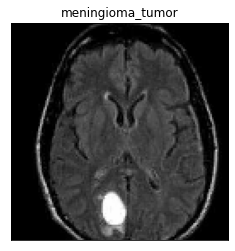

In [37]:
image_path = '../input/glioma/MRI-Brain-Images-abenign-bmalignant-images_Q320.jpg'
evaluate(image_path, model_path, dict_path)